<a href="https://colab.research.google.com/github/stephen-njiu/DeepLearningForTimeSeriesForecasting/blob/master/rnn_revisited.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [62]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, InputLayer
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv("time_series.csv", parse_dates=['Date Time'], index_col = 'Date Time')
df.head()


,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
Date Time,,,,,,,,,,,,,,
01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


In [69]:
df

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
Date Time,,,,,,,,,,,,,,
01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.30,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.40,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.90,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.20,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.10,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31.12.2016 23:20:00,1000.07,-4.05,269.10,-8.13,73.10,4.52,3.30,1.22,2.06,3.30,1292.98,0.67,1.52,240.0
31.12.2016 23:30:00,999.93,-3.35,269.81,-8.06,69.71,4.77,3.32,1.44,2.07,3.32,1289.44,1.14,1.92,234.3
31.12.2016 23:40:00,999.82,-3.16,270.01,-8.21,67.91,4.84,3.28,1.55,2.05,3.28,1288.39,1.08,2.00,215.2


In [4]:
def prepare_data(df, sequence_length):
    # Extract temperature data and convert to numpy array
    data = df['T (degC)'].values.reshape(-1, 1)

    # Normalize the data
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(data)

    # Create sequences
    X, y = [], []
    for i in range(len(scaled_data) - sequence_length):
        X.append(scaled_data[i:i+sequence_length])
        y.append(scaled_data[i+sequence_length])

    X = np.array(X)
    y = np.array(y)

    # Split into train and test sets
    train_size = int(len(X) * 0.8)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]

    return X_train, X_test, y_train, y_test, scaler

In [5]:
X_train, X_test, y_train, y_test, scaler = prepare_data(df, sequence_length=6)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((336436, 6, 1), (84109, 6, 1), (336436, 1), (84109, 1))

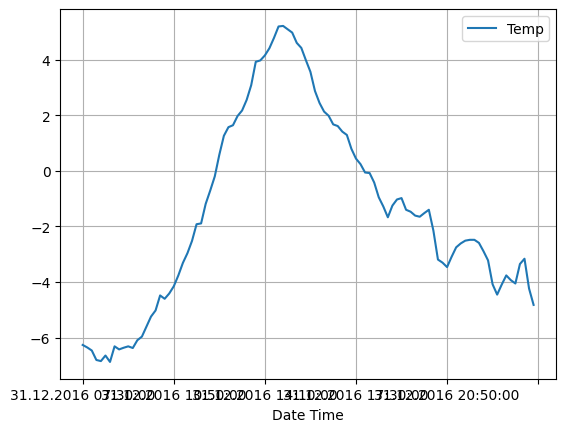

In [7]:
df['T (degC)'][-100:].plot(label = 'Temp')
plt.legend()
plt.grid()
plt.show()

In [8]:
def create_model(sequence_length):
    input_shape = (sequence_length, 1)
    model = Sequential()
    # Define the input layer explicitly
    model.add(InputLayer(input_shape))

    # First LSTM layer with Dropout to prevent overfitting
    model.add(LSTM(units=64, return_sequences=True))
    model.add(Dropout(0.2))

    # Second LSTM layer
    model.add(LSTM(units=32, return_sequences=False))

    # Dense layer for output
    model.add(Dense(1))

    # Compile the model
    model.compile(optimizer='adam', loss=MeanSquaredError())

    return model

In [49]:
def make_future_predictions(model, last_sequence, n_steps, scaler):
    future_predictions = []
    current_sequence = last_sequence.copy()

    for _ in range(n_steps):
        # Get the prediction
        current_pred = model.predict(current_sequence)

        # Append prediction
        future_predictions.append(current_pred[0, 0])

        # Update the sequence
        current_sequence = np.roll(current_sequence, -1, axis=1)
        current_sequence[0, -1, 0] = current_pred[0, 0]

    # Inverse transform predictions
    future_predictions = np.array(future_predictions).reshape(-1, 1)
    return scaler.inverse_transform(future_predictions)

In [15]:
def plot_predictions(df, predictions, future_dates):
    plt.figure(figsize=(15, 6))
    future_dates = [d.strftime('%d-%m-%Y %H:%M:%S') for d in future_dates]
    plt.plot(df.index[-future_days:], df['T (degC)'][-future_days:], label='Historical Data')
    plt.plot(future_dates, predictions, label='Predictions', color='red')
    plt.title('Temperature Forecast')
    plt.xlabel('Date')
    plt.ylabel('Temperature')
    plt.legend()
    plt.show()

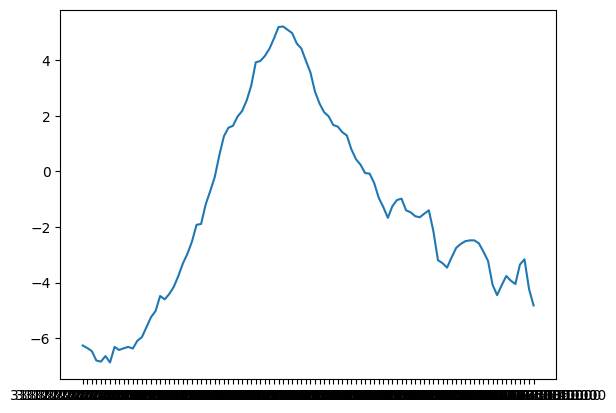

In [16]:
plt.plot(df['T (degC)'][-100:], label='Historical Data')


In [14]:
sequence_length = 6  # Using 6 days of data to predict
# Create and train the model
model = create_model(sequence_length)
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 6, 64)               │          16,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 6, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 32)                  │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 29,345 (114.63 KB)

 Trainable params: 29,345 (114.63 KB)

 Non-trainable params: 0 (0.00 B)

In [17]:
history = model.fit(
        X_train, y_train,
        epochs=5,
        batch_size=32,
        validation_data=(X_test, y_test),
        verbose=1)

Epoch 1/5
10514/10514 ━━━━━━━━━━━━━━━━━━━━ 65s 6ms/step - loss: 0.0018 - val_loss: 4.1398e-05
Epoch 2/5
10514/10514 ━━━━━━━━━━━━━━━━━━━━ 77s 6ms/step - loss: 5.4660e-05 - val_loss: 3.3424e-05
Epoch 3/5
10514/10514 ━━━━━━━━━━━━━━━━━━━━ 59s 6ms/step - loss: 4.0534e-05 - val_loss: 3.3027e-05
Epoch 4/5
10514/10514 ━━━━━━━━━━━━━━━━━━━━ 82s 6ms/step - loss: 3.6421e-05 - val_loss: 3.5244e-05
Epoch 5/5
10514/10514 ━━━━━━━━━━━━━━━━━━━━ 82s 6ms/step - loss: 3.4301e-05 - val_loss: 1.2376e-05


In [73]:
future_days = 20    # Predicting 100 days into the future

In [74]:
last_sequence = X_test[-1:].copy()  # Using the last actual sequence
predictions = make_future_predictions(model, last_sequence, future_days, scaler)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


In [75]:
last_date = df.index[-1]
future_dates = pd.date_range(start=last_date, periods=future_days+1,freq='10min')[1:]
future_dates

DatetimeIndex(['2017-01-01 00:10:00', '2017-01-01 00:20:00',
               '2017-01-01 00:30:00', '2017-01-01 00:40:00',
               '2017-01-01 00:50:00', '2017-01-01 01:00:00',
               '2017-01-01 01:10:00', '2017-01-01 01:20:00',
               '2017-01-01 01:30:00', '2017-01-01 01:40:00',
               '2017-01-01 01:50:00', '2017-01-01 02:00:00',
               '2017-01-01 02:10:00', '2017-01-01 02:20:00',
               '2017-01-01 02:30:00', '2017-01-01 02:40:00',
               '2017-01-01 02:50:00', '2017-01-01 03:00:00',
               '2017-01-01 03:10:00', '2017-01-01 03:20:00'],
              dtype='datetime64[ns]', freq='10min')

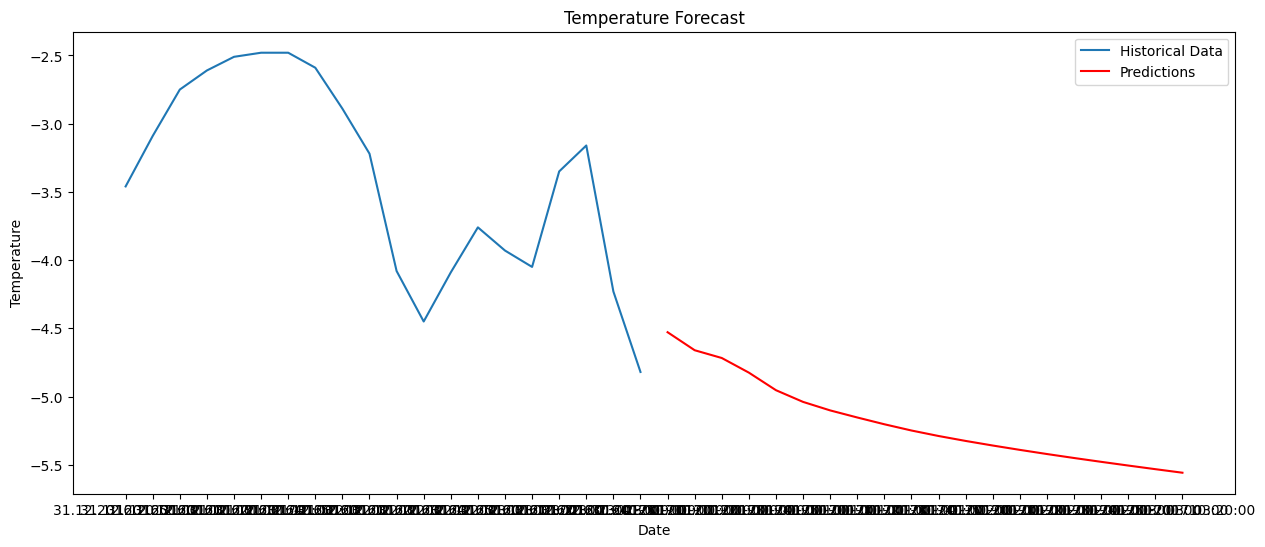

In [76]:
plot_predictions(df, predictions, future_dates)